<a href="https://colab.research.google.com/github/ManelBoucenna/AI-s-code-repository/blob/master/Character_Level_generation_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this notebook, we are going to implement an name generator using RNN at character level. 

The training dataset is: #TODO.

Followed this [tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html).

# Data preparation


1.   Import and extract dataset from zip file
2.   Transform from Unicode to ASCI
3.  Create disctionnary: {'English':listOfNames, ...}



In [53]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import requests, zipfile, io
  

In [54]:
DATA_URL = 'https://download.pytorch.org/tutorial/data.zip'
r = requests.get(DATA_URL, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()


In [55]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['English', 'Czech', 'Vietnamese', 'Chinese', 'French', 'Scottish', 'Arabic', 'German', 'Japanese', 'Spanish', 'Polish', 'Korean', 'Italian', 'Irish', 'Greek', 'Dutch', 'Portuguese', 'Russian']
O'Neal


In [56]:
category_lines['English'][0]

'Abbas'

# RNN creation
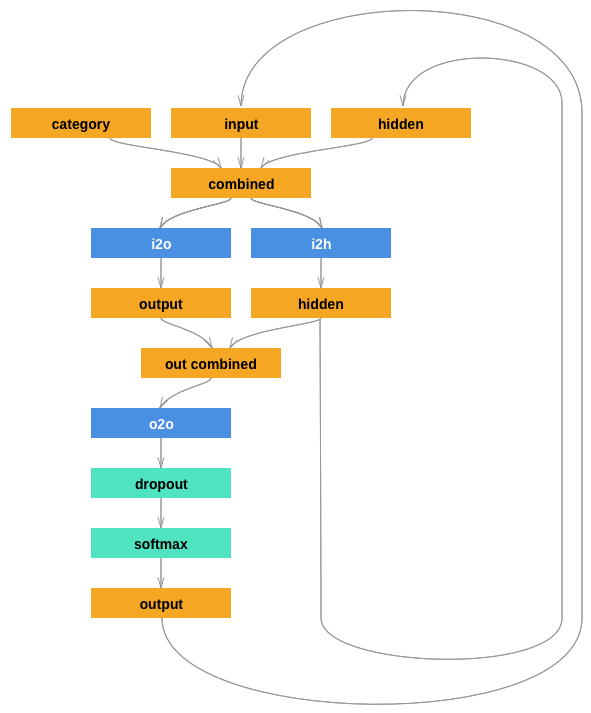

In [57]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# Training 

In [58]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [59]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [85]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    print(category, ' ', line)
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [88]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [89]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [90]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

Aruba   Babijn
Montserrat   Brades
Brunei   Tutong
Turkey   Cizre
Senegal   Kolda
Zambia   Luanshya
Honduras   Santa Rosa de Copan
Hungary   Budapest XVII. kerulet
Vatican   Vatican City
New Zealand   Waitakere
Libya   Sirte
Andorra   les Escaldes
Cocos Islands   West Island
Seychelles   Victoria
Saint Barthelemy   Gustavia
Christmas Island   Flying Fish Cove
South Sudan   Pajok
Sierra Leone   Waterloo
Grenada   Saint George's
Greece   Naousa
Anguilla   The Valley
Cook Islands   Avarua
Jamaica   Half Way Tree
Northern Mariana Islands   Saipan
Uzbekistan   Haqqulobod
Syria   Al Qunaytirah
United Arab Emirates   Dubai
Cuba   Ciro Redondo
Marshall Islands   RMI Capitol
Liberia   Buchanan
Egypt   Jirja
Chad   Pala
Northern Mariana Islands   Saipan
Isle of Man   Douglas
Mexico   Puerto Vallarta
Rwanda   Butare
Switzerland   Sankt Gallen
Tonga   Nukualofa
Angola   Cabinda
Egypt   Kafr Saqr
Austria   Klosterneuburg
Indonesia   Driyorejo
Uzbekistan   Fergana
French Southern Territories   Port-

AttributeError: ignored

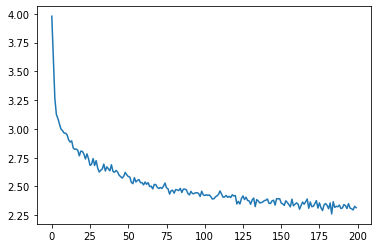

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

#Test the network (Sampling)

In [19]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))


In [21]:
samples('Arabic', 'KMN')

Kara
Maria
Nara


# Exercise:
Try Country and city names

In [138]:
import pandas as pd
import numpy as np

URL_DATASET = 'https://pkgstore.datahub.io/core/world-cities/world-cities_csv/data/6cc66692f0e82b18216a48443b6b95da/world-cities_csv.csv'
data = pd.read_csv(URL_DATASET)
data.head()

,name,country,subcountry,geonameid
0,les Escaldes,Andorra,Escaldes-Engordany,3040051
1,Andorra la Vella,Andorra,Andorra la Vella,3041563
2,Umm al Qaywayn,United Arab Emirates,Umm al Qaywayn,290594
3,Ras al-Khaimah,United Arab Emirates,Raʼs al Khaymah,291074
4,Khawr Fakkān,United Arab Emirates,Ash Shāriqah,291696


In [168]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

category_lines = {}
all_categories = []

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

for idx in data.index:
  category = data.country[idx]
  city = unicodeToAscii(data.name[idx])
  if (category in category_lines):
    category_lines[category].append(city)
  else:
    if city in {'',' '," ''"}:
      pass
    else:
      if category in {'Macedonia','Mongolia','Ukraine'}:
        pass
      else:
        all_categories.append(category)
        category_lines[category] = [city]

n_categories = len(all_categories)


In [169]:
print('Number of countries:', n_categories,' ', all_categories)
#print(category_lines['Macedonia'])

Number of countries: 241   ['Andorra', 'United Arab Emirates', 'Afghanistan', 'Antigua and Barbuda', 'Anguilla', 'Albania', 'Armenia', 'Angola', 'Argentina', 'American Samoa', 'Austria', 'Australia', 'Aruba', 'Aland Islands', 'Azerbaijan', 'Bosnia and Herzegovina', 'Barbados', 'Bangladesh', 'Belgium', 'Burkina Faso', 'Bulgaria', 'Bahrain', 'Burundi', 'Benin', 'Saint Barthelemy', 'Bermuda', 'Brunei', 'Bolivia', 'Bonaire, Saint Eustatius and Saba', 'Brazil', 'Bahamas', 'Bhutan', 'Botswana', 'Belarus', 'Belize', 'Canada', 'Cocos Islands', 'Democratic Republic of the Congo', 'Central African Republic', 'Republic of the Congo', 'Switzerland', 'Ivory Coast', 'Cook Islands', 'Chile', 'Cameroon', 'China', 'Colombia', 'Costa Rica', 'Cuba', 'Cape Verde', 'Curacao', 'Christmas Island', 'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Denmark', 'Dominica', 'Dominican Republic', 'Algeria', 'Ecuador', 'Estonia', 'Egypt', 'Western Sahara', 'Eritrea', 'Spain', 'Ethiopia', 'Finland', 'Fiji', 'Falkla

# Model creation


In [170]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


## Training

In [184]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [185]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [186]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [187]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [188]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [189]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 22s (5000 5%) 4.0827
0m 46s (10000 10%) 3.7241
1m 9s (15000 15%) 3.0652
1m 32s (20000 20%) 2.8700
1m 55s (25000 25%) 3.1454
2m 18s (30000 30%) 2.5030
2m 41s (35000 35%) 2.1031
3m 4s (40000 40%) 1.8191
3m 27s (45000 45%) 2.8648
3m 50s (50000 50%) 2.7052
4m 14s (55000 55%) 2.2221
4m 37s (60000 60%) 2.5793
5m 1s (65000 65%) 1.1992
5m 24s (70000 70%) 2.1860
5m 48s (75000 75%) 2.9350
6m 11s (80000 80%) 2.5359
6m 35s (85000 85%) 3.1804
6m 58s (90000 90%) 2.3178
7m 22s (95000 95%) 2.4213
7m 49s (100000 100%) 3.3927


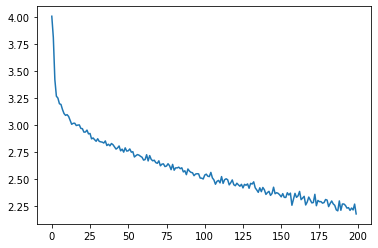

In [190]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [191]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))


In [192]:
samples('Canada', 'TMV')

Toringo
Morango
Villen
